# Stock and Tweet Data Analysis

## Install Necessary Libraries

In [36]:
# !pip install matplotlib seaborn psycopg2-binary pyspark textblob pymongo 

## Insert Stock tweets data in MongoDB

In [37]:
# import csv
# from pymongo import MongoClient

# # MongoDB connection details
# mongo_host = 'localhost'
# mongo_port = 27017
# mongo_database = 'stock_tweets'
# mongo_collection = 'tweets'

# # Connect to MongoDB
# client = MongoClient(mongo_host, mongo_port)
# db = client[mongo_database]
# collection = db[mongo_collection]

# # CSV file path
# csv_file = '/home/akshay/Downloads/stock-tweet-and-price/stocktweet/stocktweet.csv'

# # Open CSV file and insert data into MongoDB
# with open(csv_file, 'r', encoding='utf-8') as file:
#     reader = csv.DictReader(file)
#     data = []
#     for row in reader:
#         data.append(row)

# # Insert data into MongoDB collection
# collection.insert_many(data)

# # Close MongoDB connection
# client.close()

# print(f"Data from {csv_file} inserted into MongoDB collection {mongo_collection}.")

## Insert Stock price data in PostgresSQL

In [38]:
# import os
# import csv
# import psycopg2

# # PostgreSQL connection details
# pg_host = 'localhost'
# pg_port = '5432'
# pg_database = 'stock_price'
# pg_user = 'postgres'
# pg_password = 'postgresspassword'



# # Connect to PostgreSQL
# conn_pg= psycopg2.connect(
#         host=pg_host,
#         port=pg_port,
#         database=pg_database,
#         user=pg_user,
#         password=pg_password
# )
# cursor_pg = conn_pg.cursor()

# # Directory containing stock price CSVs

# csv_directory = '/home/akshay/Downloads/stock-tweet-and-price/stockprice/'

# # Insert each CSV file into PostgreSQL
# for file in os.listdir(csv_directory):
#         if file.endswith('.csv'):
#             ticker = file.split('.')[0]
#             csv_file = os.path.join(csv_directory, file)
#             with open(csv_file, 'r', encoding='utf-8') as f:
#                 reader = csv.reader(f)
#                 next(reader)  # Skip header
#                 for row in reader:
#                     cursor_pg.execute('INSERT INTO stock_prices (date, ticker ,open, high, low, close, adj_close, volume) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)',[row[0], ticker] + row[1:])
#                     conn_pg.commit()

# print(f"Data from CSVs in {csv_directory} inserted into PostgreSQL table stock_prices.")

# # Close PostgreSQL connection
# cursor_pg.close()
# conn_pg.close()

## Import necessary Libraries

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, avg, col, to_date, date_format
from pyspark.sql.types import FloatType
from textblob import TextBlob
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Initializing Spark Session

In [40]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("StockSentimentAnalysis") \
    .config("spark.driver.extraClassPath", "/home/akshay/Downloads/ycsb-0.17.0/jdbc-binding/lib/postgresql-42.2.18.jar") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()

## Function to evaluate tweets sentiment score, 0 means neutral less than 0 means negative and greater than 0 means positive sentiment

In [41]:
# Download NLTK Vader Lexicon if not already downloaded
nltk.download('vader_lexicon')

# Function to perform sentiment analysis on tweets
def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    compound_score = analyzer.polarity_scores(text)["compound"]
    return compound_score

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/akshay/nltk_data...


In [42]:
# # Function to perform sentiment analysis on tweets
# def analyze_sentiment(tweet_text):
#     analysis = TextBlob(tweet_text)
#     return analysis.sentiment.polarity

## Fetching data from both dbs

In [43]:
sentiment_udf = udf(analyze_sentiment, FloatType())

In [44]:
# Load data from PostgreSQL (stock prices)
pg_props = {
    "user": "postgres",
    "password": "postgresspassword",
    "driver": "org.postgresql.Driver"
}
stock_prices = spark.read.jdbc("jdbc:postgresql://localhost:5432/stock_price", "stock_prices", properties=pg_props)


In [45]:
stock_prices.show(5)

+----------+------+------------------+------------------+------------------+------------------+------------------+-------+
|      date|ticker|              open|              high|               low|             close|         adj_close| volume|
+----------+------+------------------+------------------+------------------+------------------+------------------+-------+
|2019-12-31|    BA| 325.4100036621094|326.57000732421875|323.32000732421875|  325.760009765625|323.83331298828125|4958800|
|2020-01-02|    BA|328.54998779296875| 333.3500061035156|327.70001220703125|333.32000732421875|331.34857177734375|4544400|
|2020-01-03|    BA| 330.6300048828125| 334.8900146484375|330.29998779296875|  332.760009765625| 330.7919006347656|3875900|
|2020-01-06|    BA|329.29998779296875| 334.8599853515625| 327.8800048828125|  333.739990234375| 331.7660827636719|5355000|
|2020-01-07|    BA|  334.260009765625|344.19000244140625| 330.7099914550781| 337.2799987792969|      335.28515625|9898600|
+----------+----

In [46]:
stock_prices.describe().filter("summary == 'count'").show()

+-------+------+-----+-----+-----+-----+---------+------+
|summary|ticker| open| high|  low|close|adj_close|volume|
+-------+------+-----+-----+-----+-----+---------+------+
|  count| 10175|10175|10175|10175|10175|    10175| 10175|
+-------+------+-----+-----+-----+-----+---------+------+



In [47]:
# Load data from MongoDB (tweets)
tweets = spark.read.format("mongo").option("uri", "mongodb://localhost:27017/stock_tweets.tweets").load()


In [48]:
tweets.show(5)

+--------------------+----------+------+------+--------------------+
|                 _id|      date|    id|ticker|               tweet|
+--------------------+----------+------+------+--------------------+
|{668c3f6f291f967e...|01/01/2020|100001|  AMZN|$AMZN Dow futures...|
|{668c3f6f291f967e...|01/01/2020|100002|  TSLA|$TSLA Daddy's dri...|
|{668c3f6f291f967e...|01/01/2020|100003|  AAPL|$AAPL We’ll been ...|
|{668c3f6f291f967e...|01/01/2020|100004|  TSLA|$TSLA happy new y...|
|{668c3f6f291f967e...|01/01/2020|100005|  TSLA|$TSLA haha just a...|
+--------------------+----------+------+------+--------------------+
only showing top 5 rows



In [49]:
tweets.describe().filter("summary == 'count'").show()

+-------+-----+-----+------+-----+
|summary| date|   id|ticker|tweet|
+-------+-----+-----+------+-----+
|  count|10000|10000| 10000|10000|
+-------+-----+-----+------+-----+



## Grouping the data for each company  for each day

In [50]:
windowSpec = Window.partitionBy("ticker").orderBy("date")

## Calculating percentage change in the stock prices for each company for each day, so that later on we can corelate and analyze with what percentage stock price is changed in respect to the sentiments of the tweets for that company

In [51]:
stock_prices = stock_prices.withColumn("percent_change", (F.col("close") - F.lag("close").over(windowSpec)) / F.lag("close").over(windowSpec) * 100)


In [52]:
stock_prices.show(5)

+----------+------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+--------------------+
|      date|ticker|             open|             high|              low|            close|        adj_close|   volume|      percent_change|
+----------+------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+--------------------+
|2019-12-31|  AAPL|72.48249816894531|73.41999816894531|72.37999725341797| 73.4124984741211|71.52082061767578|100805600|                NULL|
|2020-01-02|  AAPL|74.05999755859375| 75.1500015258789|73.79750061035156| 75.0875015258789|73.15264892578125|135480400|  2.2816319926071906|
|2020-01-03|  AAPL| 74.2874984741211| 75.1449966430664|           74.125|74.35749816894531|72.44145965576172|146322800| -0.9722035519879405|
|2020-01-06|  AAPL|73.44750213623047|74.98999786376953|          73.1875|74.94999694824219| 73.0186767578125|118387200|  0.7968245219206774|
|2020-01-07| 

## Calculating sentiment score of each tweet

In [53]:
# Perform sentiment analysis on tweets and aggregate by date and ticker
tweets = tweets.withColumn("sentiment", sentiment_udf(tweets["tweet"]))

In [54]:
tweets.show(6)

+--------------------+----------+------+------+--------------------+---------+
|                 _id|      date|    id|ticker|               tweet|sentiment|
+--------------------+----------+------+------+--------------------+---------+
|{668c3f6f291f967e...|01/01/2020|100001|  AMZN|$AMZN Dow futures...|      0.0|
|{668c3f6f291f967e...|01/01/2020|100002|  TSLA|$TSLA Daddy's dri...|      0.0|
|{668c3f6f291f967e...|01/01/2020|100003|  AAPL|$AAPL We’ll been ...|      0.0|
|{668c3f6f291f967e...|01/01/2020|100004|  TSLA|$TSLA happy new y...|   0.5719|
|{668c3f6f291f967e...|01/01/2020|100005|  TSLA|$TSLA haha just a...|   0.7717|
|{668c3f6f291f967e...|01/01/2020|100006|  TSLA|$TSLA NOBODY: Gas...|    -0.87|
+--------------------+----------+------+------+--------------------+---------+
only showing top 6 rows



## Converting date format so that we can join them and corelate the stock price with sentiment of the tweet

In [55]:
tweets = tweets.withColumn("date", to_date(col("date"), "dd/MM/yyy"))

In [56]:
tweets.show(6)

+--------------------+----------+------+------+--------------------+---------+
|                 _id|      date|    id|ticker|               tweet|sentiment|
+--------------------+----------+------+------+--------------------+---------+
|{668c3f6f291f967e...|2020-01-01|100001|  AMZN|$AMZN Dow futures...|      0.0|
|{668c3f6f291f967e...|2020-01-01|100002|  TSLA|$TSLA Daddy's dri...|      0.0|
|{668c3f6f291f967e...|2020-01-01|100003|  AAPL|$AAPL We’ll been ...|      0.0|
|{668c3f6f291f967e...|2020-01-01|100004|  TSLA|$TSLA happy new y...|   0.5719|
|{668c3f6f291f967e...|2020-01-01|100005|  TSLA|$TSLA haha just a...|   0.7717|
|{668c3f6f291f967e...|2020-01-01|100006|  TSLA|$TSLA NOBODY: Gas...|    -0.87|
+--------------------+----------+------+------+--------------------+---------+
only showing top 6 rows



## Calculating average sentiment for each company day wise to gain a better understanding whether people are positive about it or negative

In [57]:
tweets_grouped = tweets.groupBy("date", "ticker").agg(avg("sentiment").alias("avg_sentiment"))


In [58]:
tweets_grouped.show(5)

+----------+------+--------------------+
|      date|ticker|       avg_sentiment|
+----------+------+--------------------+
|2020-02-06|  AAPL|-0.07245001196861267|
|2020-05-14|   MCD|  0.6840999722480774|
|2020-06-05|  AAPL|-0.27320000529289246|
|2020-08-25|    BA|    0.05052500218153|
|2020-09-17|  NFLX| 0.12209999987057277|
+----------+------+--------------------+
only showing top 5 rows



## Joining both processed data, stock price and stock tweets

In [59]:
# Join stock prices and sentiment scores
joined_data = stock_prices.join(tweets_grouped, (stock_prices.date == tweets_grouped.date) & (stock_prices.ticker == tweets_grouped.ticker), "inner")


In [60]:
joined_data.show(5)

+----------+------+-----------------+------------------+------------------+------------------+------------------+---------+-------------------+----------+------+--------------------+
|      date|ticker|             open|              high|               low|             close|         adj_close|   volume|     percent_change|      date|ticker|       avg_sentiment|
+----------+------+-----------------+------------------+------------------+------------------+------------------+---------+-------------------+----------+------+--------------------+
|2020-02-06|  AAPL|80.64250183105469| 81.30500030517578| 80.06500244140625| 81.30249786376953| 79.20750427246094|105425600| 1.1696932976394614|2020-02-06|  AAPL|-0.07245001196861267|
|2020-05-14|   MCD|170.1999969482422|175.66000366210938|167.85000610351562|175.41000366210938| 161.0229949951172|  4868400| 1.4986669529712875|2020-05-14|   MCD|  0.6840999722480774|
|2020-06-05|  AAPL| 80.8375015258789|           82.9375| 80.80750274658203|          

## Selecting only the desired columns

In [61]:
# Select relevant columns and sort by date and ticker
result = joined_data.select(stock_prices.date, stock_prices.ticker, stock_prices.percent_change, tweets_grouped.avg_sentiment).orderBy("date", "ticker")

# Output results
result.show()


+----------+------+--------------------+--------------------+
|      date|ticker|      percent_change|       avg_sentiment|
+----------+------+--------------------+--------------------+
|2020-01-02|  AAPL|  2.2816319926071906| 0.34187500178813934|
|2020-01-02|   DIS|   2.468361989147618|                 0.0|
|2020-01-02|    HD|  0.5861336892925478| -0.3321000039577484|
|2020-01-02|  TSLA|  2.8518175015711247|-0.32910001277923584|
|2020-01-03|  AAPL| -0.9722035519879405|  0.0085166667898496|
|2020-01-03|  AMZN| -1.2139034655920933|                 0.0|
|2020-01-03| GOOGL| -0.5231342883399271| 0.44040000438690186|
|2020-01-03|  NVDA| -1.6005986742007217|                 0.0|
|2020-01-03|  TSLA|  2.9633258297920753| 0.04648333663741747|
|2020-01-06|  AAPL|  0.7968245219206774|  0.7793000042438507|
|2020-01-06|  AMZN|  1.4885573930506535| 0.44040000438690186|
|2020-01-06|  NFLX|  3.0469447259134697|                 0.0|
|2020-01-06|  TSLA|  1.9254637045135075|  0.2869500070810318|
|2020-01

## Plotting graph for a company for visual understanding that if for a day sentiment are positive then stock prices also goes up or not (Note: Plot can be visualised for different companies by changing the value of ticker variable)

In [62]:
# Convert joined data to pandas DataFrame for plotting
joined_data_pd = result.toPandas()


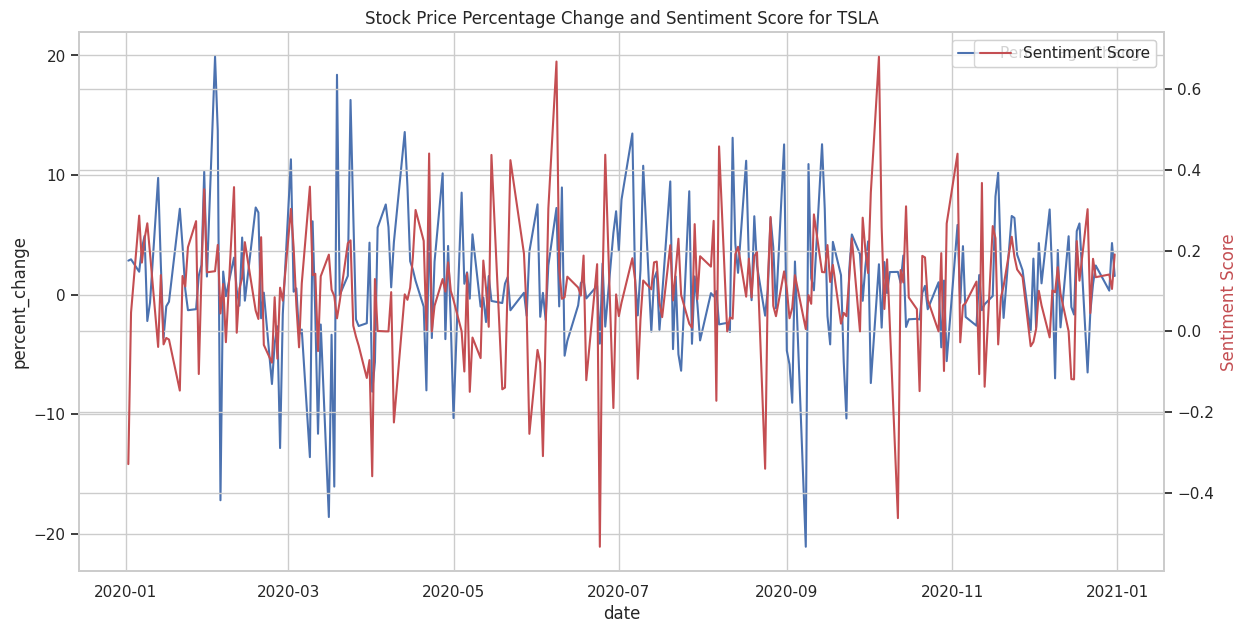

In [63]:
# Filter data for a specific ticker
ticker = "TSLA"
ticker_data = joined_data_pd[joined_data_pd["ticker"] == ticker]

# Plotting
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Plot percentage change
sns.lineplot(data=ticker_data, x="date", y="percent_change", label="Percentage Change", color="b")

# Create a secondary y-axis for sentiment scores
ax2 = plt.gca().twinx()
sns.lineplot(data=ticker_data, x="date", y="avg_sentiment", label="Sentiment Score", color="r", ax=ax2)

# Set axis labels and title
plt.title(f"Stock Price Percentage Change and Sentiment Score for {ticker}")
plt.xlabel("Date")
plt.ylabel("Percentage Change", color="b")
ax2.set_ylabel("Sentiment Score", color="r")

# Display the plot
plt.show()

## Stopping the Spark Session

In [64]:
# Stop Spark session
spark.stop()